In [36]:
import requests
import json
import sys
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn as sk
import torch
import test_utils_models
from importlib import reload
from torch.utils.data import DataLoader, TensorDataset
import Transformer
import TransformerV3
import TransformerServiceV2
import torch.optim as optim
import torch.nn as nn
import test_utils
import DataVisualizations
import Utilities

In [4]:
url = 'http://localhost:8000/sequenceset_manager/get_sequence_data'

# features = ['pctChgclose', 'pctChgvolume', 'opHi', 'opCl','hiCl','loCl','opLo',"pctDiff+ema5_close", "pctDiff+ema10_close", "pctDiff+ema20_close",'pctDiff+ema50_close', 'pctDiff+ema100_close',
# 'pctDiff+ema200_close','pctDiff+bb_high_close10', 'pctDiff+bb_low_close10', 'pctDiff+smaVol10_volume', 'pctDiff+smaVol20_volume', 'pctChgClOp', 'macd_signal','bb_indicator20',"bb_indicator50",
#             ]
# struct_features = ['open', 'high', 'low', 'close', 'ema20', 'ema50', 'ema100']
# struct_features = ['close']
struct_features = []
# features = ['pctChgclose','pctChgvolume','opHi', 'opCl','hiCl','loCl','opLo']
# features = ['pctChgclose']
features = ['open', 'high', 'low', 'close', 'ema20', 'ema50', 'ema100']
# target_features = ['pctChgclose+{}'.format(i) for i in range(1, 3) ]
target_features = ['close+{}'.format(i) for i in range(1, 15) ]
# target_features = ['cumPctChg+{}'.format(i) for i in range(1,11) ]

indices_seq = list(range(len(features + struct_features + target_features)))

feature_dict = {col: index for col, index in zip(features+struct_features + target_features, indices_seq)}


In [5]:
print(feature_dict)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'ema20': 4, 'ema50': 5, 'ema100': 6, 'close+1': 7, 'close+2': 8, 'close+3': 9, 'close+4': 10, 'close+5': 11, 'close+6': 12, 'close+7': 13, 'close+8': 14, 'close+9': 15, 'close+10': 16, 'close+11': 17, 'close+12': 18, 'close+13': 19, 'close+14': 20}


In [7]:
# tickers = ['MSFT', 'AAPL', 'AMZN','QQQ','SPY','F', 'TSLA', "BAC", "LLY", "PEP" ]
tickers = ['AAPL', 'MSFT']
# tickers = ["AAPL", "SPY", "QQQ", "XOM", "MSFT", "AMZN", "BB", 'F', 'TSLA', 'GE',
#            "JPM", "BAC", "LLY", "NKE", "WMT", "PEP"]
sequence_lengths = [20]
all_sequences = []

all_params = []

for ticker in tickers:
    for sequence_length in sequence_lengths:
        all_params.append({
            'ticker': ticker,
            'features': features + struct_features + target_features,
            'interval': '1d',
            'start_date': '2018-01-01',
            'sequence_length': sequence_length
        })
for params in all_params:

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            data = response.json()
            all_sequences.append(data)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            print("Response text:", response.text)
    else:
        print(f"Request failed with status code {response.status_code}")

In [8]:
print(len(all_sequences))

2


In [9]:
print(all_sequences[-1][-500]['end_timestamp'])
print(all_sequences[-1][-500]['start_timestamp'])


2022-09-19T00:00:00Z
2022-08-22T00:00:00Z


In [10]:
target_feauture_index = [feature_dict[col] for col in target_features]
for index in target_feauture_index:
    print(all_sequences[-1][-500]['sliced_data'][-1][index])

242.4499969482422
238.9499969482422
240.97999572753906
237.9199981689453
237.4499969482422
236.41000366210938
241.07000732421875
237.5
232.89999389648438
240.74000549316406
248.8800048828125
249.1999969482422
246.7899932861328
234.24000549316406


In [11]:
def create_3d_array(stock_sequences, max_len_seq):
    # Create a 3D array to store the sequences
    # The array will have the shape (num_sequences, sequence_length, num_features)
    # stock sequences is a list of sequence_dicts where each sequence_dict is a dictionary
    # we are extracting 'sliced_data' from each sequence_dict and creating 3d np array

    num_features = len(features) + len(struct_features)

    sequence_steps = len(stock_sequences[0]['sliced_data'])

    num_sequences = len(stock_sequences)
    X = np.zeros((num_sequences, sequence_steps, num_features))
    y = np.zeros((num_sequences, len(target_features)))

    indices_map = {}
    cur_index = 0
    for i, sequence_dict in enumerate(stock_sequences):
        X_cols = [feature_dict[col] for col in features + struct_features]
        y_cols = [feature_dict[col] for col in target_features]

        X[i, :, :] = np.array(sequence_dict['sliced_data'])[:, X_cols]
        X_padded = np.zeros((num_sequences, max_len_seq, num_features))
        X_padded[:, :sequence_steps, :] = X
        y[i, :] = np.array(sequence_dict['sliced_data'])[-1, y_cols]




    return X_padded, y

In [12]:
def preprocess_multi_stock(all_sequences, max_seq_length, test_size=0.1):
    X_train = np.zeros((0, 0, 0))
    X_test = np.zeros((0, 0, 0))
    y_train = np.zeros((0, 0))
    y_test = np.zeros((0, 0))
    
    test_seq_objs = []
    train_seq_objs = []
    for sequences in all_sequences:
        print(len(sequences))
        X, y = create_3d_array(sequences,max_seq_length)
        print(X.shape)

        for i in range(len(X)-1, 0, -1):
            if np.isnan(y[i]).any():
                X = np.delete(X, i, axis=0)
                y = np.delete(y, i, axis=0)

        X_train_cur, X_test_cur, y_train_cur, y_test_cur = train_test_split(X, y, test_size=test_size, shuffle=False)
        
        train_seq_objs += [sequences[i] for i in range(len(X_train_cur))]
        test_seq_objs += [sequences[i] for i in range(len(X_train_cur), len(X_train_cur)+len(X_test_cur))]

        # scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
        # X_train_cur = scaler.fit_transform(X_train_cur)
        # X_test_cur = scaler.transform(X_test_cur)
        # 
        y_scaler = sk.preprocessing.StandardScaler()
        # y_train_cur = y_scaler.fit_transform(y_train_cur)
        # y_test_cur = y_scaler.transform(y_test_cur)
        
        # X_train_cur = X_train_cur[0:-25, :, :]
        # y_train_cur = y_train_cur[0:-25, :]
        # X_test_cur = X_test_cur[0:-25, :, :]
        # y_test_cur = y_test_cur[0:-25, :]


        if X_train.shape[0] == 0:
            X_train = X_train_cur
            X_test = X_test_cur
            y_train = y_train_cur
            y_test = y_test_cur
        else:
            X_train = np.concatenate((X_train, X_train_cur), axis=0)
            X_test = np.concatenate((X_test, X_test_cur), axis=0)
            y_train = np.concatenate((y_train, y_train_cur), axis=0)
            y_test = np.concatenate((y_test, y_test_cur), axis=0)

    return X_train, X_test, y_train, y_test, y_scaler, train_seq_objs, test_seq_objs


In [13]:
X_train_whole, X_test, y_train_whole, y_test, y_scaler,train_seq_objs, test_seq_objs = preprocess_multi_stock(all_sequences, max(sequence_lengths))

1667
(1667, 20, 7)
1667
(1667, 20, 7)


In [14]:
def sample_training_data(X_train, y_train, percentage=0.3):
    # Get the number of samples
    num_samples = X_train.shape[0]

    # Calculate the number of samples for 30%
    num_samples_to_sample = int(percentage * num_samples)

    # Randomly sample indices (without replacement)
    sampled_indices = np.random.choice(num_samples, num_samples_to_sample, replace=False)

    # Extract the same indices from both X_train and y_train
    X_sampled = X_train[sampled_indices]
    y_sampled = y_train[sampled_indices]

    return X_sampled, y_sampled

In [15]:
## sample random 30% of the sequences for training set and get rid of the rest
X_train, y_train = sample_training_data(X_train_whole, y_train_whole, percentage=1)

In [16]:


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2974, 20, 7) (332, 20, 7) (2974, 14) (332, 14)


In [17]:
print(feature_dict)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'ema20': 4, 'ema50': 5, 'ema100': 6, 'close+1': 7, 'close+2': 8, 'close+3': 9, 'close+4': 10, 'close+5': 11, 'close+6': 12, 'close+7': 13, 'close+8': 14, 'close+9': 15, 'close+10': 16, 'close+11': 17, 'close+12': 18, 'close+13': 19, 'close+14': 20}


In [18]:
if len(struct_features) > 0:
    X_train_scaled = Utilities.scale_sequence_by_group(struct_features, feature_dict, X_train)
    X_test_scaled = Utilities.scale_sequence_by_group(struct_features, feature_dict, X_test)
else:
    X_train_scaled = X_train
    X_test_scaled = X_test

In [19]:
x_indices = [feature_dict[col] for col in features]

# scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
# X_train_scaled[:,:,x_indices] = scaler.fit_transform(X_train[:,:,x_indices])
# X_test_scaled[:,:,x_indices] = scaler.transform(X_test[:,:,x_indices])
# 
# y_train_scaled = y_scaler.fit_transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
X_train_scaled = X_train
X_test_scaled = X_test
y_train_scaled = y_train
y_test_scaled = y_test

In [20]:
y_train_scaled = np.expand_dims(y_train_scaled, axis=2)
y_test_scaled = np.expand_dims(y_test_scaled, axis=2)
print(y_train_scaled.shape, y_test_scaled.shape)

(2974, 14, 1) (332, 14, 1)


In [21]:
print(X_train_scaled.shape, X_test_scaled.shape)

(2974, 20, 7) (332, 20, 7)


In [22]:
print(X_train_scaled[0,:,-1])

[52.57562023 52.69927131 52.82606794 52.97065072 53.10964777 53.26183293
 53.41298476 53.57599497 53.74800499 53.88809397 54.0252604  54.18693838
 54.38036538 54.57827894 54.77044175 54.95934385 55.1553469  55.35098367
 55.55294445 55.74971779]


In [23]:
# DataVisualizations.plot_feature_histograms(X_test_scaled, features + struct_features, feature_dict)


In [24]:
# DataVisualizations.plot_y_feature_histograms(y_train_scaled, target_features)

In [25]:
# DataVisualizations.plot_y_feature_histograms(y_test_scaled, target_features)

In [26]:
# DataVisualizations.plot_y_feature_histograms(np.expand_dims(y_scaler.inverse_transform(y_train_scaled.squeeze()),-1), target_features)


In [27]:
# DataVisualizations.plot_y_feature_histograms(np.expand_dims(y_train,-1), target_features)


In [28]:
reload(DataVisualizations)

<module 'DataVisualizations' from '/Users/andrewpassero/Documents/TradeLensForcast/DataVisualizations.py'>

In [29]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    print("MPS is available. Setting as default device.")
    device = torch.device("mps")
    torch.set_default_device(device)

print(f"Using device: {device}")
batch_size = 64

# Convert data to tensors and move them to the appropriate device
print(X_train_scaled.shape)
print(y_train_scaled.shape)
# X_train_scaled_concat = np.concatenate((X_train_scaled, y_train_scaled), axis=-1)
# print(X_train_scaled_concat.shape)
# X_test_scaled_concat = np.concatenate((X_test_scaled, y_test_scaled), axis=-1)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

print(X_train_tensor.device, X_test_tensor.device, y_train_tensor.device, y_test_tensor.device)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

generator = torch.Generator(device=device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

MPS is available. Setting as default device.
Using device: mps
(2974, 20, 7)
(2974, 14, 1)
mps:0 mps:0 mps:0 mps:0


In [30]:
print(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape)

torch.Size([2974, 20, 7]) torch.Size([2974, 14, 1]) torch.Size([332, 20, 7]) torch.Size([332, 14, 1])


In [56]:
num_layers = 1
d_model = 64
num_heads = 2
d_ff = 128
input_dim = X_train_tensor.shape[2]  # Number of features in X_train
output_dim = y_train.shape[1]  # Since y_train has shape (batch, output_steps, 1)

# Initialize the Transformer models
model = TransformerV3.Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    encoder_input_dim=input_dim,
    decoder_input_dim=output_dim,
    dropout=.2
).to(device)
print(next(model.parameters()).device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f'The model has {count_parameters(model):,} trainable parameters')

Initializing TransformerEncoder with 1 layers
PositionalEncoding initialized with shape: torch.Size([1, 200, 64])
TransformerEncoder initialized with 1 layers
Transformer initialized with 1 layers
mps:0
The model has 84,418 trainable parameters


In [209]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# base_optimizer = optim.Adam
# optimizer = torch.optim.SGD(models.parameters(), lr=1e-3, momentum=0.9)

# optimizer = Transformer.SAM(models.parameters(), base_optimizer, rho=0.3, lr=0.01)
# criterion = nn.MSELoss()
# get mae criterian 
# criterion = nn.L1Loss()
# criterion = nn.HuberLoss(delta=1.0)
criterion = Transformer.gaussian_nll_loss
# Initialize the Trainer with the device
trainer = TransformerServiceV2.Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_length=14,
    start_token_value=-999 # Start token value, adjust if necessary
)

In [210]:
from importlib import reload
reload(Transformer)
reload(TransformerServiceV2)
reload(TransformerV3)

<module 'TransformerV3' from '/Users/andrewpassero/Documents/TradeLensForcast/TransformerV3.py'>

In [211]:
epochs = 2000

# Train the models

trainer.fit(train_dataloader, test_dataloader, epochs=epochs, clip_value=1)

Epoch 1 | Train Loss: 3.319 | Val Loss: 4.767
Epoch 2 | Train Loss: 3.276 | Val Loss: 4.888
Epoch 3 | Train Loss: 3.273 | Val Loss: 5.960
Epoch 4 | Train Loss: 3.274 | Val Loss: 5.497
Epoch 5 | Train Loss: 3.246 | Val Loss: 5.635
Epoch 6 | Train Loss: 3.274 | Val Loss: 5.311
Epoch 7 | Train Loss: 3.266 | Val Loss: 4.770
Epoch 8 | Train Loss: 3.308 | Val Loss: 5.152
Epoch 9 | Train Loss: 3.273 | Val Loss: 5.779
Epoch 10 | Train Loss: 3.351 | Val Loss: 7.557
Epoch 11 | Train Loss: 3.263 | Val Loss: 4.945
Epoch 12 | Train Loss: 3.241 | Val Loss: 6.170
Epoch 13 | Train Loss: 3.259 | Val Loss: 4.733
Epoch 14 | Train Loss: 3.239 | Val Loss: 5.028
Epoch 15 | Train Loss: 3.244 | Val Loss: 5.930
Epoch 16 | Train Loss: 3.291 | Val Loss: 5.432
Epoch 17 | Train Loss: 3.261 | Val Loss: 6.032
Epoch 18 | Train Loss: 3.234 | Val Loss: 4.815
Epoch 19 | Train Loss: 3.262 | Val Loss: 4.943
Epoch 20 | Train Loss: 3.267 | Val Loss: 4.977
Epoch 21 | Train Loss: 3.254 | Val Loss: 6.004
Epoch 22 | Train Loss:

KeyboardInterrupt: 

In [220]:
# file_path = "saved_models/model_weights20240928_171203.pth"
# models.load_state_dict(torch.load(file_path, map_location=device))

/var/folders/d8/cz684bdx7pbc12fnsyp2z9mm0000gn/T/ipykernel_42368/3875937369.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<All keys matched successfully>

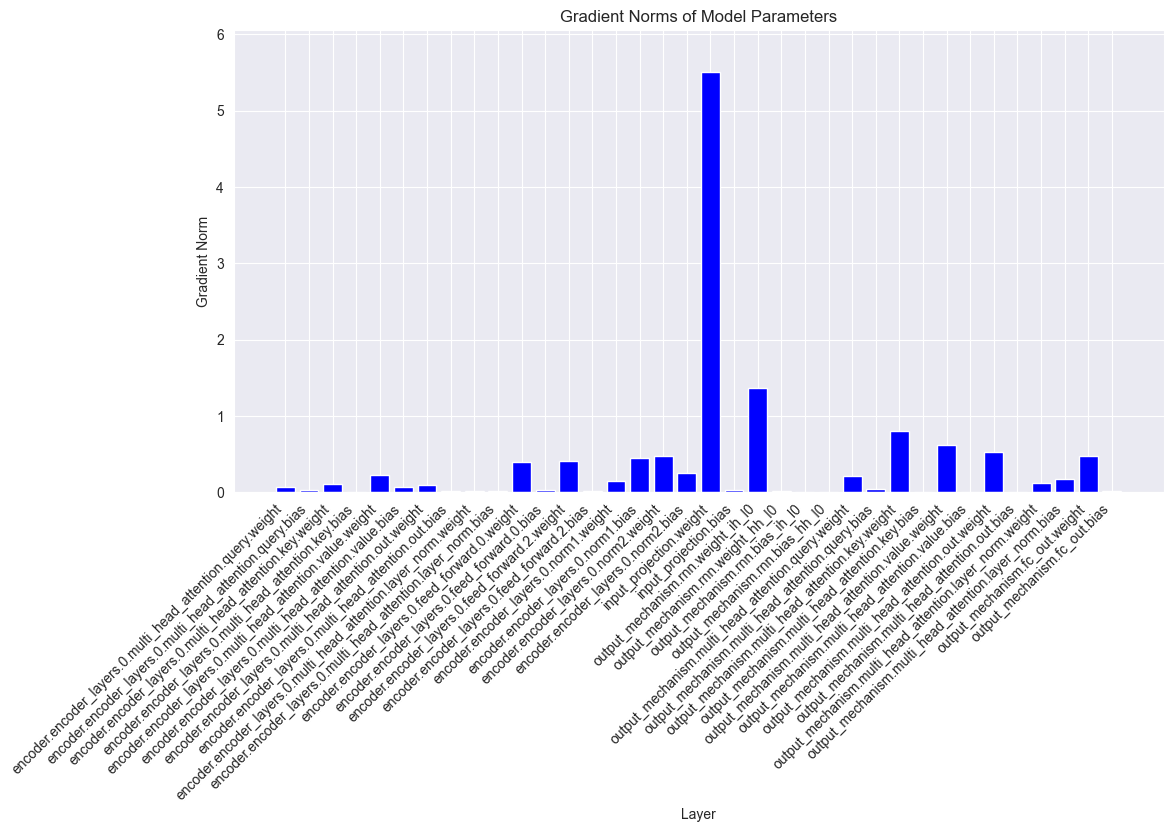

In [190]:
gradient_test_X = X_train_tensor[-64:]
gradient_test_y = y_train_tensor[-64:]

gradients = trainer.log_gradients_with_names(gradient_test_X, gradient_test_y)
DataVisualizations.visualize_gradients(gradients)

In [191]:
# y_pred = trainer.predict(X_test_tensor)
y_pred = trainer.predict(X_train_tensor[:64])
# y_pred = trainer.sequence_predictions
print(y_pred.shape)

Predictions shape: torch.Size([64, 14, 2])
torch.Size([64, 14, 2])


In [192]:
mu_pred = y_pred[:, :, 0]
log_var_pred = y_pred[:, :, 1]
variance_pred = torch.exp(log_var_pred)
std_pred = torch.sqrt(variance_pred)
print(mu_pred.shape, std_pred.shape)


torch.Size([64, 14]) torch.Size([64, 14])


In [193]:
# mu_pred_denorm = y_scaler.inverse_transform(mu_pred.detach().cpu().numpy())
# std_pred_denorm = y_scaler.inverse_transform(std_pred.detach().cpu().numpy())
mu_pred_denorm = mu_pred.detach().cpu().numpy()
std_pred_denorm = std_pred.detach().cpu().numpy()

In [194]:
trainer.generate_model_architecture()

Model Architecture:
------------------
'transformer_encoder'
'transformer_encoder:encoder_layer0'
'transformer_encoder:encoder_layer0:multi_head_attention'



In [195]:
# retrieval_list = ["transformer_encoder:encoder_layer0:multi_head_attention",
# "transformer_encoder:encoder_layer1:multi_head_attention",
# "transformer_decoder:decoder_layer0:self_attention",
# "transformer_decoder:decoder_layer0:cross_attention",
# "transformer_decoder:decoder_layer1:self_attention",
# "transformer_decoder:decoder_layer1:cross_attention"]
retrieval_list = ['transformer_encoder:encoder_layer0:multi_head_attention',"transformer_decoder:decoder_layer0:cross_attention"]
retrieval_dict = trainer.retreive_attention_scores(retrieval_list)

In [196]:
print(retrieval_dict['transformer_encoder:encoder_layer0:multi_head_attention'].shape)
print(len(retrieval_dict))

torch.Size([64, 20, 64])
1


In [197]:
retrieval_list = ['transformer_encoder:encoder_layer0', 'transformer_decoder:decoder_layer0']
output_dict = trainer.retrieve_output(retrieval_list)

In [198]:
print(y_pred.shape)

torch.Size([64, 14, 2])


In [199]:
reload(test_utils)
reload(Transformer)
reload(TransformerV3)
reload(TransformerServiceV2)
reload(DataVisualizations)

<module 'DataVisualizations' from '/Users/andrewpassero/Documents/TradeLensForcast/DataVisualizations.py'>

In [200]:
mu_pred = mu_pred_denorm.squeeze()
std_pred = std_pred_denorm.squeeze()

In [201]:
print(mu_pred.shape)

(64, 14)


In [202]:
output_string, results, predicted_y_old = test_utils.eval_model(y_train[:64], mu_pred, num_days = y_pred.shape[1], alreadyCum=True)

(64, 14)
14


In [203]:
print(output_string)

Cluster Number:
Accuracy1D 100.0% PredictedRet: 153.82766723632812 ActRet: 155.96281164884567
Accuracy2D 100.0% PredictedRet: 154.572021484375 ActRet: 155.32816302776337
Accuracy3D 100.0% PredictedRet: 154.6158447265625 ActRet: 155.59156209230423
Accuracy4D 100.0% PredictedRet: 154.78567504882812 ActRet: 155.10191386938095
Accuracy5D 100.0% PredictedRet: 154.63104248046875 ActRet: 154.97132855653763
Accuracy6D 100.0% PredictedRet: 154.65728759765625 ActRet: 155.42746078968048
Accuracy7D 100.0% PredictedRet: 154.71466064453125 ActRet: 154.80230498313904
Accuracy8D 100.0% PredictedRet: 154.7581787109375 ActRet: 155.82300865650177
Accuracy9D 100.0% PredictedRet: 154.85977172851562 ActRet: 155.61250030994415
Accuracy10D 100.0% PredictedRet: 154.97293090820312 ActRet: 154.86562556028366
Accuracy11D 100.0% PredictedRet: 155.01402282714844 ActRet: 155.53746151924133
Accuracy12D 100.0% PredictedRet: 155.10018920898438 ActRet: 156.53742170333862
Accuracy13D 100.0% PredictedRet: 155.010406494140

In [204]:
test_utils.visualize_future_distribution(results)

(64, 29)


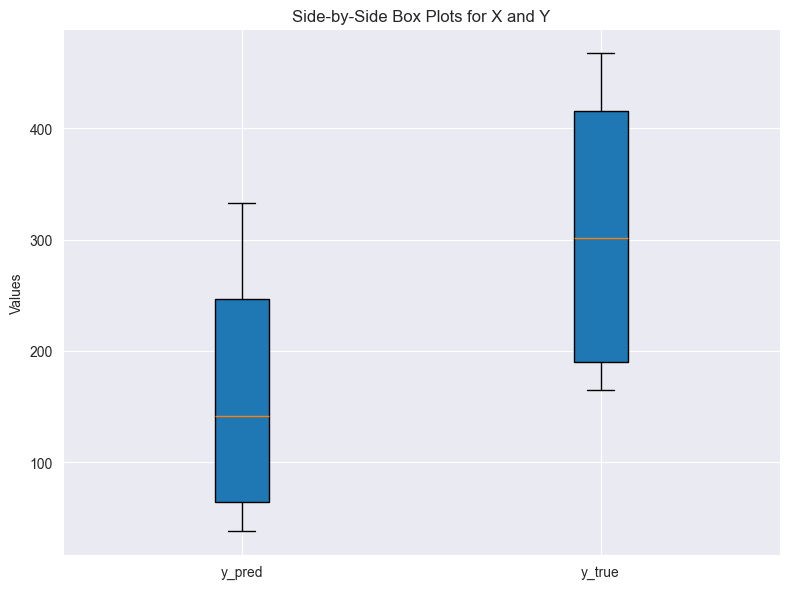

In [205]:
DataVisualizations.visualize_step_distribution(mu_pred,y_test)

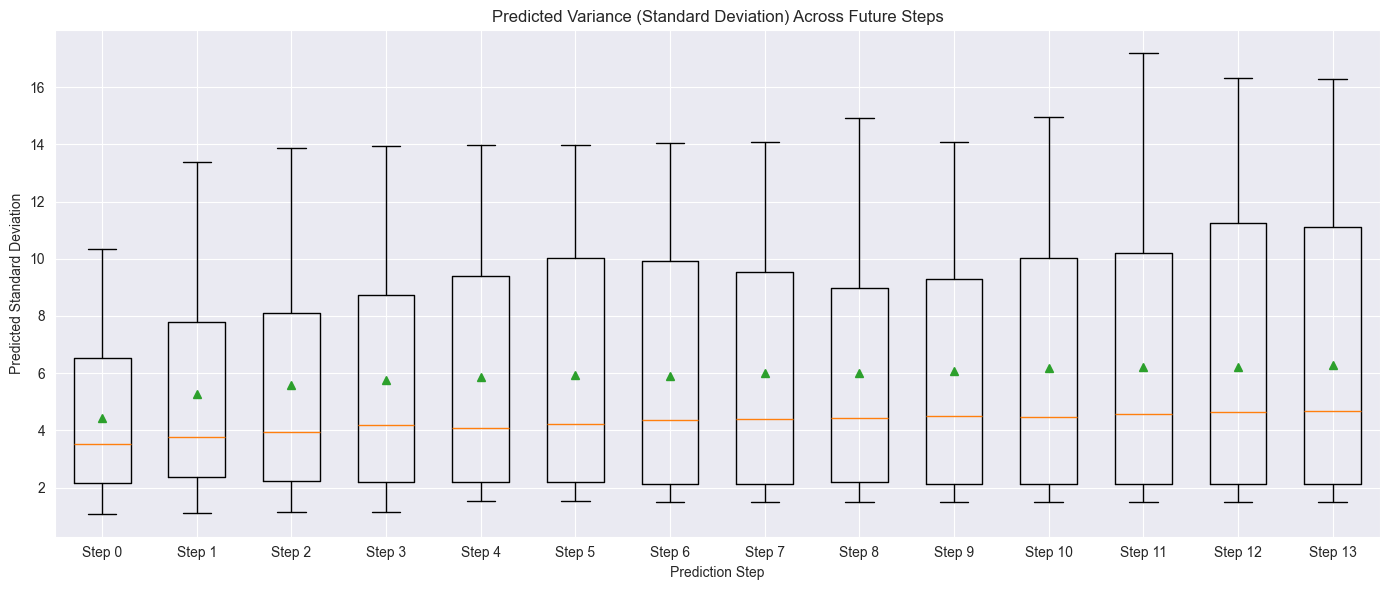

In [207]:
# visualize variance
DataVisualizations.visualize_std(std_pred)

In [179]:
DataVisualizations.plot_residuals(y_test ,mu_pred, std_pred)

ValueError: operands could not be broadcast together with shapes (332,14) (64,14) 

TypeError: 'Axes' object is not subscriptable

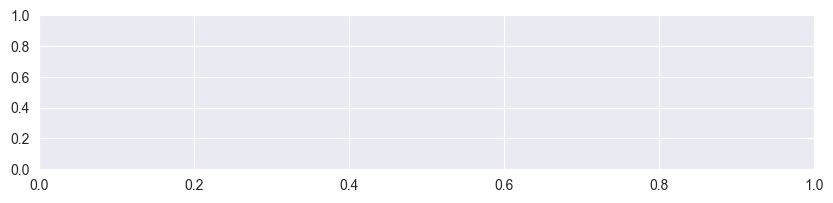

In [180]:
DataVisualizations.plot_layer_activations(model, X_test_tensor)

2023-11-29T00:00:00Z
2023-12-27T00:00:00Z
[66.11750031 65.66000366 66.44000244 66.77500153 66.57250214 65.79750061
 65.50250244 65.44499969 66.59249878 66.07250214 66.95999908 66.8125
 66.04000092 64.86250305]
[63.75095  64.26265  64.340385 64.353134 64.35233  64.35503  64.35565
 64.35625  64.35628  64.35629  64.35629  64.35642  64.35645  64.35645 ]


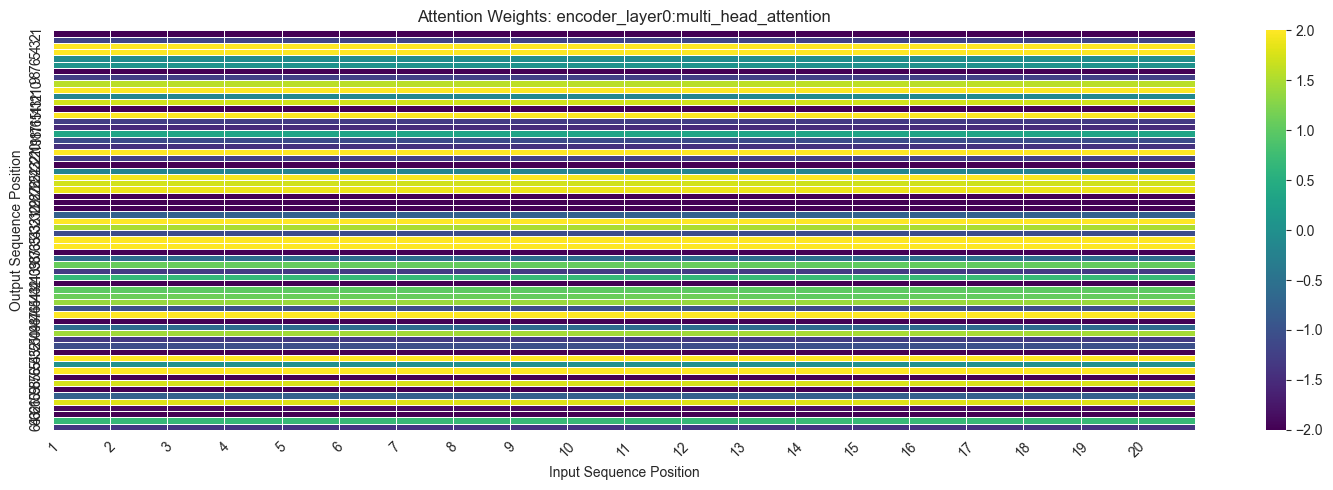

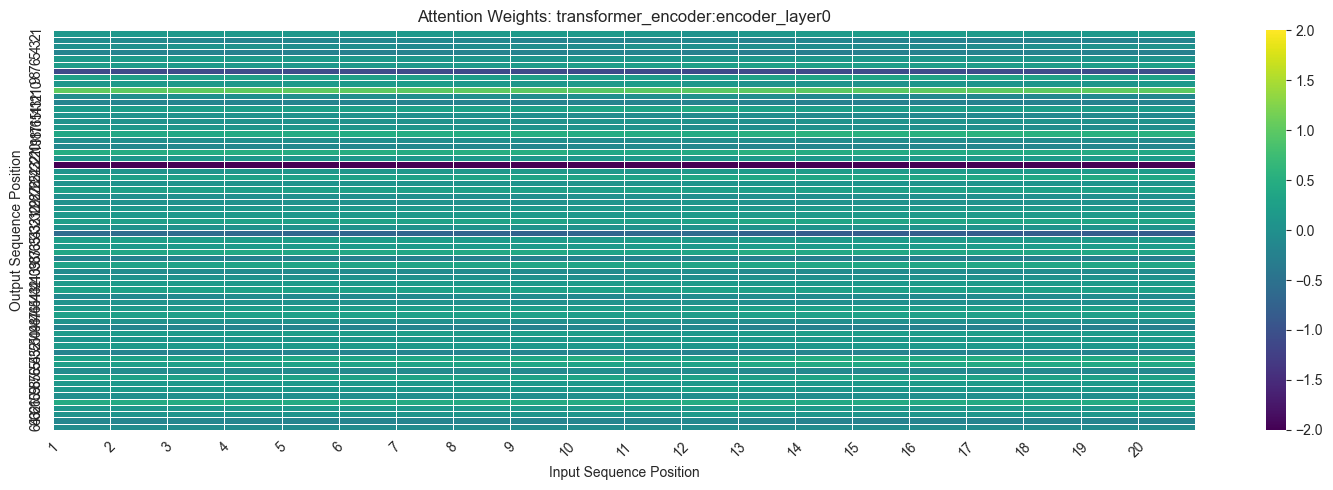

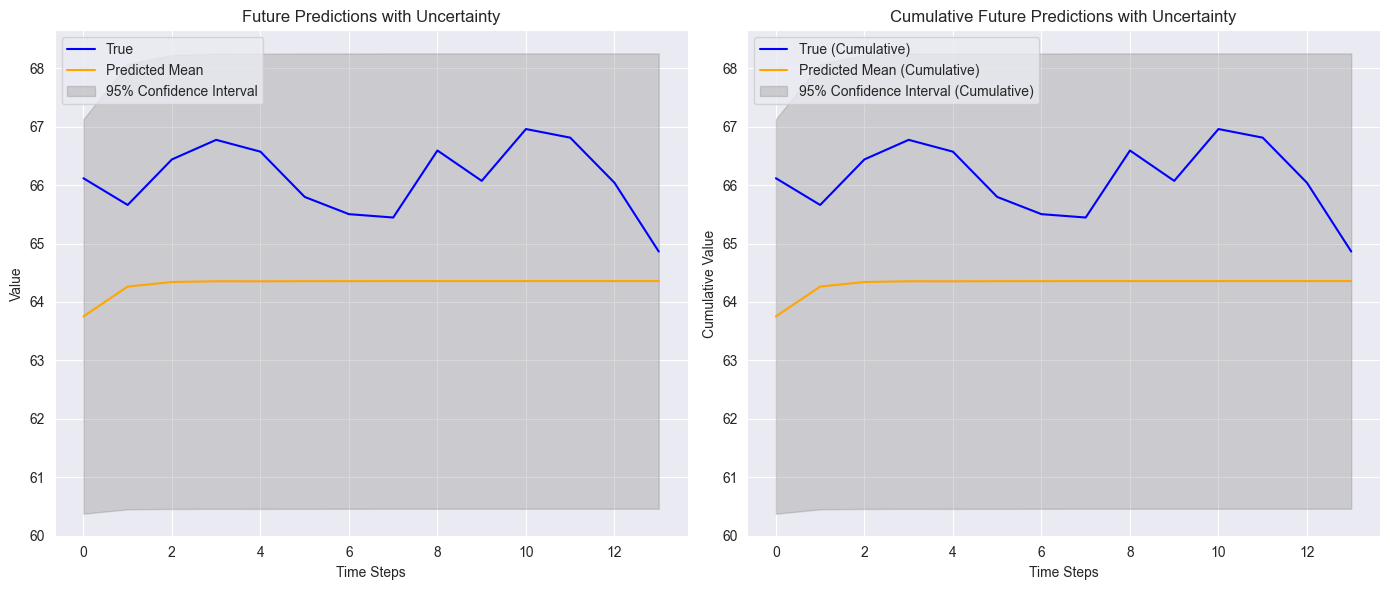

In [208]:
for i in range(0, 1):

    # print(test_seq_objs[i]['ticker'])
    print(test_seq_objs[i]['start_timestamp'])
    print(test_seq_objs[i]['end_timestamp'])
    print(y_train[i])
    print(mu_pred[i])
    DataVisualizations.layer_heatmap(retrieval_dict, i)
    DataVisualizations.layer_heatmap(output_dict, i)
    DataVisualizations.visualize_future_predictions_with_uncertainty(y_train[i], mu_pred[i], std_pred[i], already_cumulative=True)

In [ ]:
# embeddings = DataVisualizations.extract_embeddings(models, X_test_tensor[:1000])
# DataVisualizations.visualize_embeddings(embeddings, method='tsne', perplexity=50)

In [60]:
from datetime import datetime

# add date/time to models name
model_name = 'model_weights' + datetime.now().strftime("%Y%m%d_%H%M%S")
print(model_name)
torch.save(model.state_dict(), 'saved_models/' + model_name + '.pth')

model_weights20240928_171203
